# Machine Learning II
## Urban Sound Classification: Deep Learning Approaches for Audio Recognition
#### Work assembled by Alejandro Gonçalves, Francisca Mihalache, Alexandre Lusquinhos

### Table of contents <a name="contents"></a>
1. [Introduction](#introduction)
2. [Data Understanding](#data-understanding)
3. [Data Reading](#data-reading)
    - 3.1. [Feature Extraction](#feature-extraction)
    - 3.2. [Data Cleaning](#data-cleaning)
      
      - 3.2.1. [Reading](#reading)
      
      - 3.2.2. [Cleaning](#cleaning)
5. [Classifiers](#classifiers)

   - 4.1. [Multilayer Perceptron (MLP)](#multilayer)
   - 4.2. [Convolutional neural network (CNN)](#convolutional)
   
   
  

## Introduction <a name="introduction"></a>
[[go back to the top]](#contents)

The objective of this project is to develop **deep learning classifiers** for urban sound data. In this assignment, we will implement two of the three classifiers provided by the professor, as outlined in the [[PDF]](./Project.pdf). 

The classifiers are:

• A classifier based on a multilayer perceptron (MLP)

• A classifier based on a convolutional neural network (CNN)

• A classifier based on a recurrent neural network (RNN)

And for each of the chosen classifier, the implementation will need to consider the following steps:
1. Data pre-processing and preparation
2. Model architecture definition
3. Training strategies
4. Performance evaluation

## Data Understanding <a name="data-understanding"></a>
[[go back to the top]](#contents)


The dataset consists of 8,732 labeled sound excerpts, each lasting up to 4 seconds, categorized into 10 distinct classes:
- air_conditioner [0] 
- car_horn [1] 
- children_playing [2] 
- dog_bark [3] 
- drilling [4] 
- enginge_idling [5] 
- gun_shot [6] 
- jackhammer [7] 
- siren [8] 
- street_music [9] 

The sound classes in the UrbanSound and UrbanSound8K datasets are derived from the UrbanSound taxonomy, as presented on the https://urbansounddataset.weebly.com/taxonomy.html

Below is an image showcasing the taxonomy structure from the referenced site:

![Descrição da imagem](./taxonomy.png)

All audio excerpts are derived from field recordings uploaded to http://www.freesound.org/

The dataset comprises 8,732 urban sound audio files in WAV format. The sampling rate, bit depth, and number of channels correspond to those of the original files uploaded to Freesound, which may vary across different recordings.

In addition to the audio excerpts, a CSV file containing metadata for each excerpt is also included.

This is a short explanation of the csv:

| Name of the Column | Brief Explanation                                                                                       |
|--------------------|--------------------------------------------------------------------------------------------------------|
| slice_file_name    | The name of the audio file, formatted as [fsID]-[classID]-[occurrenceID]-[sliceID].wav.              |
| fsID               | The Freesound ID of the recording from which this excerpt (slice) is taken.                           |
| start              | The start time of the slice in the original Freesound recording.                                      |
| end                | The end time of the slice in the original Freesound recording.                                        |
| salience           | A subjective salience rating of the sound (1 = foreground, 2 = background).                           |
| fold               | The fold number (1-10) to which this file has been allocated.                                         |
| classID            | A numeric identifier of the sound class (0-9) as listed above.                                        |
| [occurrenceID]     | A numeric identifier to distinguish different occurrences of the sound within the original recording. |
| [sliceID]          | A numeric identifier to distinguish different slices taken from the same occurrence.                 |


**To avoid common pitfalls**:
-  Don't reshuffle the data! Use the predefined 10 folds and perform 10-fold (not 5-fold) cross validation
-  Don't evaluate just on one split! Use 10-fold (not 5-fold) cross validation and average the scores

## Data Reading <a name="data-reading"></a>
[[go back to the top]](#contents)


After carefully analyzing the three available classifiers, we decided to implement MLP and CNN for this project. Our decision was based on several important considerations, which we have outlined in detail in the following [[Notes]](./Notas.md).

Let's explore what we have and outline what we'll be working on in the coming days.



#### Imports

In [1]:
import pandas as pd
import librosa
import os
import numpy as np
import soundfile as sf
from sklearn.preprocessing import MinMaxScaler
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [7]:
path_csv = 'UrbanSound8K/metadata/UrbanSound8K.csv'

df = pd.read_csv(path_csv)

print(df.head())


      slice_file_name    fsID  start        end  salience  fold  classID   
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3  \
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


##### Check if there's any missing values

In [8]:
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64


##### Visualizing graphically

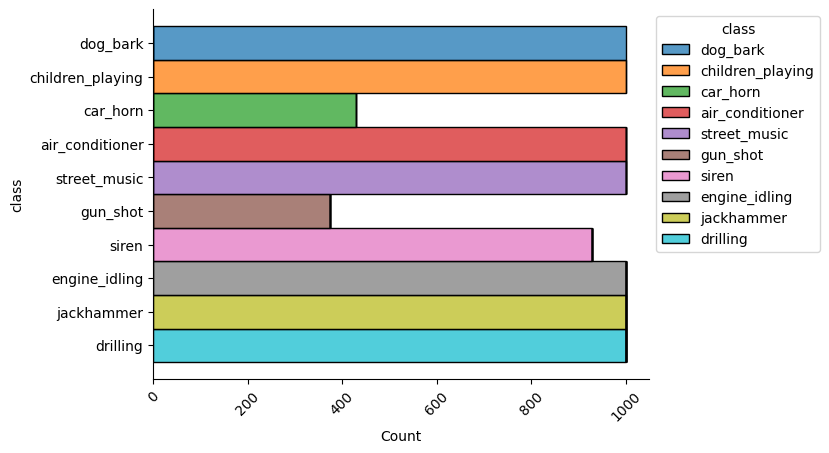

In [ ]:
ax = sns.histplot(y='class',data = df, hue="class", multiple="stack")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
sns.despine()
plt.show()

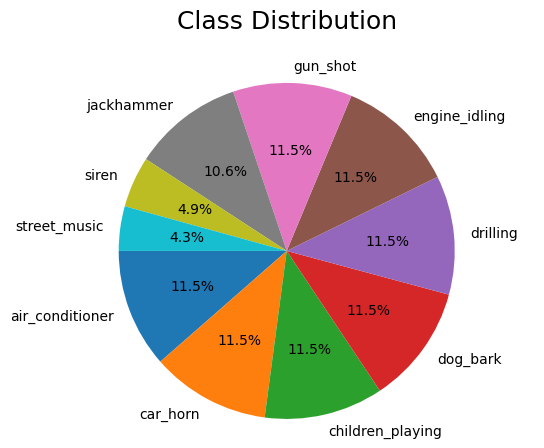

In [10]:
class_dict = df['class'].value_counts(normalize=True)
classes = list(np.unique(df['class']))
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08, fontsize=18)
ax.pie(class_dict, labels=classes, autopct='%1.1f%%', shadow=False, startangle=180)
ax.axis('equal')
plt.savefig("distribution_class")
plt.show(block=False)

##### Accessing the audio data

In [19]:
# Path to the folder where the audio dubs are located
base_path = 'UrbanSound8K/audio'

# Go through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        # Browse the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Upload audio using librosa
                audio, sample_rate = librosa.load(file_path)
                
                # Example: Process audio or extract features
                print(f"File: {file_name}, Sample Rate: {sample_rate}, Duration: {len(audio)/sample_rate:.2f}s")


File: 135776-2-0-49.wav, Sample Rate: 22050, Duration: 4.00s
File: 46654-6-0-0.wav, Sample Rate: 22050, Duration: 1.14s
File: 57320-0-0-24.wav, Sample Rate: 22050, Duration: 4.00s
File: 134717-0-0-26.wav, Sample Rate: 22050, Duration: 4.00s
File: 174276-7-5-0.wav, Sample Rate: 22050, Duration: 2.87s
File: 180937-7-2-6.wav, Sample Rate: 22050, Duration: 4.00s
File: 17913-4-0-1.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-4-6.wav, Sample Rate: 22050, Duration: 4.00s
File: 176787-5-0-9.wav, Sample Rate: 22050, Duration: 4.00s
File: 55020-4-0-11.wav, Sample Rate: 22050, Duration: 4.00s
File: 138015-3-0-7.wav, Sample Rate: 22050, Duration: 4.00s
File: 180937-7-0-4.wav, Sample Rate: 22050, Duration: 4.00s
File: 180937-7-1-13.wav, Sample Rate: 22050, Duration: 4.00s
File: 157867-8-0-10.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-2-0.wav, Sample Rate: 22050, Duration: 1.38s
File: 113205-5-1-4.wav, Sample Rate: 22050, Duration: 4.00s
File: 57584-4-0-8.wav, Sample Rate: 22

##### As observed, some audio clips have varying durations, such as 1.64, 2.61, and up to 4 seconds. To simplify the processing and ensure consistency, we will standardize all audio data to the same length. This allows for uniform input to our models, improving training efficiency and performance. How can we do that?

##### Well, there's four strategies:
- **Zeropadding:** Ideal for maintaining the integrity of short audios.
- **Audio Repetition:** Works well for rhythmic or repetitive sounds.
- **Discard Short Audios:** Simple and effective when you can afford to lose some data.
- **Interpolation:** Suitable if you want to maintain consistency in the timing of the audio, but can change the way it sounds.

Although we already thought and started with an approach (Zeropadding), we had a conversation with the teacher about what would be the best strategy to perform, and we came with the conclusion that **Audio Repetition** would be the best.


##### Audio Repetition

In [21]:
# Target duration and sample rate
target_duration = 4.0  # seconds
sample_rate = 22050  # sample rate

# Path to the folder where the audio files are located
base_path = 'UrbanSound8K/audio'

# Loop through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        print(f"\nProcessing files in {fold_path}...")
        
        # Loop through the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio with librosa
                audio, sr = librosa.load(file_path, sr=sample_rate)
                
                # Check if the audio is shorter than the target duration
                if len(audio) < target_duration * sample_rate:
                    # Calculate the number of samples required
                    target_samples = int(target_duration * sample_rate)
                    audio_repeated = np.tile(audio, int(np.ceil(target_samples / len(audio))))
                    audio_repeated = audio_repeated[:target_samples]
                else:
                    audio_repeated = audio
                
                # Save the adjusted audio, replacing the original (or in a new directory)
                sf.write(file_path, audio_repeated, sample_rate)
                print(f"File {file_name} processed with duration of {target_duration} seconds.")


Processing files in UrbanSound8K/audio/fold1...
File 135776-2-0-49.wav processed with duration of 4.0 seconds.
File 46654-6-0-0.wav processed with duration of 4.0 seconds.
File 57320-0-0-24.wav processed with duration of 4.0 seconds.
File 134717-0-0-26.wav processed with duration of 4.0 seconds.
File 174276-7-5-0.wav processed with duration of 4.0 seconds.
File 180937-7-2-6.wav processed with duration of 4.0 seconds.
File 17913-4-0-1.wav processed with duration of 4.0 seconds.
File 103074-7-4-6.wav processed with duration of 4.0 seconds.
File 176787-5-0-9.wav processed with duration of 4.0 seconds.
File 55020-4-0-11.wav processed with duration of 4.0 seconds.
File 138015-3-0-7.wav processed with duration of 4.0 seconds.
File 180937-7-0-4.wav processed with duration of 4.0 seconds.
File 180937-7-1-13.wav processed with duration of 4.0 seconds.
File 157867-8-0-10.wav processed with duration of 4.0 seconds.
File 103074-7-2-0.wav processed with duration of 4.0 seconds.
File 113205-5-1-4.w

##### Checking if there's still audios with duration different than 4 seconds

In [23]:
# Path to the folder where the audio files are located
base_path = 'UrbanSound8K/audio'

# Expected duration (4 seconds)
expected_duration = 4.0  # in seconds

# Variables to count audio files with correct and incorrect durations
correct_duration_count = 0
incorrect_duration_files = []

# Loop through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        # Loop through the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio using librosa
                audio, sample_rate = librosa.load(file_path)
                duration = len(audio) / sample_rate
                
                # Check if the audio is exactly 4 seconds
                if abs(duration - expected_duration) < 0.01:  # Tolerance of 0.01 seconds
                    correct_duration_count += 1
                else:
                    incorrect_duration_files.append((file_name, duration))

# Display results
print(f"Number of audio files with 4-second duration: {correct_duration_count}")
if incorrect_duration_files:
    print("Audio files with a duration different from 4 seconds:")
    for file_name, duration in incorrect_duration_files:
        print(f"{file_name} - Duration: {duration:.2f} seconds")
else:
    print("All audio files are 4 seconds long.")

Number of audio files with 4-second duration: 8725
Audio files with a duration different from 4 seconds:
36429-2-0-14.wav - Duration: 4.04 seconds
36429-2-0-15.wav - Duration: 4.04 seconds
36429-2-0-13.wav - Duration: 4.04 seconds
36429-2-0-7.wav - Duration: 4.04 seconds
36429-2-0-6.wav - Duration: 4.04 seconds
36429-2-0-23.wav - Duration: 4.04 seconds
36429-2-0-18.wav - Duration: 4.04 seconds


##### Okay, we still have files with more than 4 seconds. For that we have a strategy called Trimming.

In [24]:
# Target duration and sample rate
target_duration = 4.0  # seconds
sample_rate = 22050  # sample rate

# Path to the folder where the audio files are located
base_path = 'UrbanSound8K/audio'

# Loop through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        print(f"\nProcessing files in {fold_path}...")
        
        # Loop through the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio with librosa
                audio, sr = librosa.load(file_path, sr=sample_rate)
                
                # Check if the audio duration is greater than 4 seconds
                if len(audio) > target_duration * sample_rate:
                    # Trim audio to exactly 4 seconds
                    audio = audio[:int(target_duration * sample_rate)]
                    print(f"Trimming {file_name} to {target_duration} seconds.")
                    
                    # Save the trimmed audio, replacing the original file
                    sf.write(file_path, audio, sample_rate)



Processing files in UrbanSound8K/audio/fold1...

Processing files in UrbanSound8K/audio/fold2...

Processing files in UrbanSound8K/audio/fold3...

Processing files in UrbanSound8K/audio/fold4...

Processing files in UrbanSound8K/audio/fold5...
Trimming 19007-4-0-0.wav to 4.0 seconds.

Processing files in UrbanSound8K/audio/fold6...

Processing files in UrbanSound8K/audio/fold7...

Processing files in UrbanSound8K/audio/fold8...
Trimming 36429-2-0-14.wav to 4.0 seconds.
Trimming 36429-2-0-15.wav to 4.0 seconds.
Trimming 36429-2-0-13.wav to 4.0 seconds.
Trimming 36429-2-0-7.wav to 4.0 seconds.
Trimming 36429-2-0-6.wav to 4.0 seconds.
Trimming 36429-2-0-23.wav to 4.0 seconds.
Trimming 36429-2-0-18.wav to 4.0 seconds.

Processing files in UrbanSound8K/audio/fold9...

Processing files in UrbanSound8K/audio/fold10...


##### Let's see now if all the files have 4 seconds.

In [25]:
# Path to the folder where the audio files are located
base_path = 'UrbanSound8K/audio'

# Expected duration (4 seconds)
expected_duration = 4.0  # in seconds

# Variables to count audio files with correct and incorrect durations
correct_duration_count = 0
incorrect_duration_files = []

# Loop through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        # Loop through the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio using librosa
                audio, sample_rate = librosa.load(file_path)
                duration = len(audio) / sample_rate
                
                # Check if the audio is exactly 4 seconds
                if abs(duration - expected_duration) < 0.01:  # Tolerance of 0.01 seconds
                    correct_duration_count += 1
                else:
                    incorrect_duration_files.append((file_name, duration))

# Display results
print(f"Number of audio files with 4-second duration: {correct_duration_count}")
if incorrect_duration_files:
    print("Audio files with a duration different from 4 seconds:")
    for file_name, duration in incorrect_duration_files:
        print(f"{file_name} - Duration: {duration:.2f} seconds")
else:
    print("All audio files are 4 seconds long.")

Number of audio files with 4-second duration: 8732
All audio files are 4 seconds long.


##### Great! Now, let's begin the feature extraction.

## Feature Extraction <a name="feature-extraction"></a>
[[go back to the top]](#contents)

As described in [[Notes]](./Notas.md) and in [[PDF]](./Project.pdf), we will need to extract features, and for that we'll use **Mel-Frequency Cepstral Coefficients (MFCCs)** which are well known for their success in environmental sound classification.

We will create a csv to save those features. The provided code returns a set of CSV files, one for each folder (fold) in the dataset, structured as follows:
- Numerical values of extracted features, including:
    - Spectral features (e.g., chroma_stft, rms, centroid, bandwidth, rolloff).
    - Rhythmic features (e.g., tempogram, fourier_tempogram).
    - Mel-Frequency Cepstral Coefficients (MFCCs 1–25).
    - Label: The filename of the audio file for identification.

For this feature extraction we will follow the instructions mentioned in the [[Article]](./Research/salamon_urbansound_acmmm14.pdf) and in [[Summary]](./Research/Summary.md), such that:
- **Frame-Based Analysis**: Audio slices are analyzed per frame, with each frame windowed at **23.2 ms** and a 50% overlap between frames.

- **Frequency Bands**: Computed across **40 Mel bands** from 0 to 22050 Hz.
    
- **Coefficients**: The first **25 MFCC coefficients** are extracted for each frame to summarize the sound’s spectral properties.

In [26]:
def extract_features(audio_file, target_duration=4, target_sr=22050):
    # Load audio and define target sample rate
    y, sr = librosa.load(audio_file, sr=target_sr)

    # Normalize amplitude
    y = librosa.util.normalize(y)

    # Define frame parameters
    frame_size = int(target_sr * 0.0232)  # 23.2 ms frame size
    hop_length = frame_size // 2         # 50% overlap

    # Onset envelope
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

    # Spectral feature list
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr, hop_length=hop_length)
    melspectogram = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length, n_mels=40)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=25, hop_length=hop_length)  # First 25 coefficients
    rms = librosa.feature.rms(y=y, hop_length=hop_length)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=hop_length)
    flatness = librosa.feature.spectral_flatness(y=y, hop_length=hop_length)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)
    crossing_rate = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)

    # Rhythm feature list
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)
    fourier_tempogram = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)

    # Create a dictionary to store the mean value of the features
    features = {
        'chroma_stft': np.mean(chroma_stft),
        'chroma_cens': np.mean(chroma_cens),
        'melspectogram': np.mean(melspectogram),
        'rms': np.mean(rms),
        'centroid': np.mean(centroid),
        'bandwidth': np.mean(bandwidth),
        'contrast': np.mean(contrast),
        'flatness': np.mean(flatness),
        'rolloff': np.mean(rolloff),
        'crossing_rate': np.mean(crossing_rate),
        'tempogram': np.mean(tempogram),
        'fourier_tempogram': np.mean(fourier_tempogram)
    }

    # Add the mean of each of the first 25 MFCC features to the dictionary
    for i in range(1, 26):
        features[f'mfcc_{i}'] = np.mean(mfccs[i - 1])
    return features

def process_data(base_dir):
    for folder in os.listdir(base_dir):
        label_list = []
        features_list = []
        fold_dir = os.path.join(base_dir, folder)
        if os.path.isdir(fold_dir):
            for filename in os.listdir(fold_dir):
                file_path = os.path.join(fold_dir, filename)
                if filename.endswith('.wav'):
                    label = filename
                    features = extract_features(file_path)
                    features_list.append(features)
                    label_list.append(label)

        # Create DataFrame for each folder
        df = pd.DataFrame(features_list)
        df['Label'] = label_list
        # Save DataFrame as a CSV file
        df.to_csv(f'urbansounds_features_{folder}.csv', index=False)
        print(df.head())

def main():
    base_dir = 'UrbanSound8K/audio'
    process_data(base_dir)

if __name__ == '__main__':
    main()


/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cens  melspectogram       rms     centroid   
0     0.615318     0.282266       7.946588  0.203161  1291.321363  \
1     0.489774     0.277843       3.705976  0.120413  2727.122325   
2     0.449924     0.268427       6.782376  0.184459  1792.881723   
3     0.538423     0.269474       4.747178  0.148329  1636.675997   
4     0.460374     0.272147       2.236176  0.064656  2377.276079   

     bandwidth   contrast      flatness      rolloff  crossing_rate  ...   
0  1520.062704  21.286242  8.064155e-07  2546.332387       0.036185  ...  \
1  3021.580274  22.655620  6.209326e-05  6711.513559       0.080719  ...   
2  2231.530364  20.963602  1.955426e-05  3856.994982       0.039587  ...   
3  2046.689926  20.805972  1.342967e-05  3260.973345       0.034586  ...   
4  2208.643759  20.684862  7.634267e-05  4351.636307       0.066876  ...   

     mfcc_17   mfcc_18   mfcc_19    mfcc_20   mfcc_21    mfcc_22   mfcc_23   
0   2.213631 -1.326957  1.572660  -7.904691 -4.382

/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cens  melspectogram       rms     centroid   
0     0.709935     0.278948       7.527989  0.233386   833.935056  \
1     0.568295     0.270496       0.413234  0.080234  4331.470402   
2     0.235471     0.244129       3.781766  0.140286   702.949723   
3     0.533168     0.277103       0.915660  0.076183  3201.896395   
4     0.418425     0.272840       3.502075  0.114735  1389.193314   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...   
0  1390.390864  19.105450  0.000014  1449.321487       0.015223  ...  \
1  2642.043999  20.745417  0.000026  7294.963788       0.173485  ...   
2   864.769368  23.205735  0.000006  1049.090188       0.022970  ...   
3  2760.857029  22.034685  0.000033  6562.274770       0.102432  ...   
4  1626.425008  21.348101  0.000019  2442.089279       0.037354  ...   

    mfcc_17   mfcc_18   mfcc_19   mfcc_20    mfcc_21    mfcc_22   mfcc_23   
0  1.649502  5.639888  5.515823 -1.201391   6.234916  -0.756584  2.351751  

/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cens  melspectogram       rms     centroid   
0     0.510235     0.281658       6.346012  0.092005  1934.469599  \
1     0.265618     0.248076       8.104565  0.214354  1592.055423   
2     0.607745     0.269765      12.187322  0.254353  1436.213226   
3     0.309780     0.279915       9.572628  0.237496  1285.039400   
4     0.259974     0.259794       6.640235  0.196102  1768.714368   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...   
0  2157.974093  19.608708  0.000024  3724.932967       0.049603  ...  \
1  1359.952345  25.182823  0.000005  2427.775300       0.055156  ...   
2  1742.114839  20.125871  0.000005  3063.502670       0.034890  ...   
3  1379.603530  23.614660  0.000008  1764.851371       0.051741  ...   
4  1485.332390  24.932791  0.000012  2868.459148       0.058839  ...   

    mfcc_17   mfcc_18   mfcc_19    mfcc_20   mfcc_21   mfcc_22   mfcc_23   
0 -3.504719 -4.926289 -2.304158  -3.246583  0.461403 -1.843461 -0.148037  \


/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cens  melspectogram       rms     centroid   
0     0.774499     0.246765       2.671454  0.194526   774.094282  \
1     0.240615     0.162350      18.543489  0.314650  1436.189332   
2     0.746400     0.210786      14.154792  0.335421   943.142933   
3     0.621044     0.263247       5.351238  0.197613  2866.285570   
4     0.493421     0.276932       1.978935  0.055904  1038.284630   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...   
0  1754.732932  20.175652  0.000006  1471.477037       0.005176  ...  \
1  1530.124893  29.043243  0.000005  2318.740121       0.043447  ...   
2  1728.431677  19.878876  0.000003  1732.489331       0.007395  ...   
3  2731.174036  20.582791  0.000037  5929.721369       0.082930  ...   
4  1691.242265  20.543941  0.000013  1416.274866       0.020935  ...   

     mfcc_17    mfcc_18    mfcc_19    mfcc_20    mfcc_21    mfcc_22   mfcc_23   
0   3.051635   4.992457   7.670131   3.992922   5.382926   4.705205  5.

/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(


   chroma_stft  chroma_cens  melspectogram       rms     centroid   
0     0.368480     0.264425       5.671830  0.165782  1289.247510  \
1     0.565100     0.279903       4.276949  0.078901  2120.135190   
2     0.310085     0.203161      11.715309  0.236958  1442.266153   
3     0.441436     0.280709       5.669695  0.179280  2105.573909   
4     0.443058     0.282736       4.164433  0.145204  1104.994908   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...   
0   963.463876  23.455323  0.000031  2427.775300       0.050527  ...  \
1  2241.997279  18.576115  0.000768  4450.900639       0.066742  ...   
2  1912.677522  23.998181  0.000011  2643.356270       0.032960  ...   
3  1981.564776  21.706520  0.000022  3938.335723       0.065363  ...   
4  1463.413126  20.475332  0.000014  1618.226438       0.032914  ...   

     mfcc_17   mfcc_18   mfcc_19    mfcc_20    mfcc_21   mfcc_22   mfcc_23   
0 -15.399500 -9.945376  5.893735  -6.190708 -13.617734  1.792737  2.758556

/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cens  melspectogram       rms     centroid   
0     0.490188     0.282805       0.944876  0.057635  2937.992172  \
1     0.330347     0.277392       4.795773  0.176941  2221.828442   
2     0.418269     0.279438       5.263000  0.181438  1607.484924   
3     0.321193     0.249371       4.241344  0.126929  1274.106202   
4     0.170815     0.187333      15.126536  0.248916  1137.634144   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...   
0  2391.609253  20.882050  0.000136  5435.391218       0.100546  ...  \
1  2004.198284  21.990135  0.000016  4321.514716       0.073213  ...   
2  2037.760217  20.055832  0.000013  3051.055732       0.038432  ...   
3  1754.754949  21.826015  0.000007  2138.757395       0.027749  ...   
4  1027.750653  23.490851  0.000017  1494.317168       0.036963  ...   

    mfcc_17   mfcc_18   mfcc_19    mfcc_20   mfcc_21   mfcc_22   mfcc_23   
0 -3.961302  6.347301  9.213814  -4.072162  7.453804 -7.234417 -0.143131  \


/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cens  melspectogram       rms     centroid   
0     0.350304     0.268477       2.180159  0.109407  2128.781759  \
1     0.557573     0.286914       2.055740  0.133274  2698.122148   
2     0.626652     0.271901       2.807935  0.163664  2191.935651   
3     0.522626     0.282112       9.592302  0.213379   907.411171   
4     0.708883     0.236376       4.785410  0.198452  3708.483725   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...   
0  1878.506128  23.609106  0.000012  4030.692005       0.067559  ...  \
1  1501.923366  21.978187  0.000011  4269.424280       0.109128  ...   
2  2325.010680  20.886596  0.000021  4526.889197       0.050496  ...   
3  1419.762371  21.135180  0.000006  1371.963766       0.019507  ...   
4  2723.696499  21.652606  0.000096  6987.088771       0.134702  ...   

     mfcc_17    mfcc_18    mfcc_19    mfcc_20    mfcc_21   mfcc_22   mfcc_23   
0  -7.781542  -5.670235  -1.246437  -6.065276  -0.217272 -5.949829  2.87

/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cens  melspectogram       rms     centroid   
0     0.627395     0.238475      11.379734  0.267115  1212.586198  \
1     0.662908     0.263294       8.286684  0.259715  1154.694927   
2     0.710051     0.269987       7.154589  0.207764  1809.209895   
3     0.582768     0.254697       8.820900  0.215518  1858.407724   
4     0.497908     0.279175       2.261806  0.160796  4200.084981   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...   
0  1802.613558  19.582713  0.000020  2477.998696       0.021984  ...  \
1  1548.147780  20.049033  0.000003  2339.713212       0.018658  ...   
2  2477.936648  21.154941  0.000008  4466.210373       0.019384  ...   
3  2295.238228  20.701167  0.000018  4474.238648       0.041349  ...   
4  2460.799007  22.941682  0.000030  6851.915022       0.177397  ...   

     mfcc_17   mfcc_18   mfcc_19    mfcc_20   mfcc_21    mfcc_22   mfcc_23   
0  -3.384343  0.350476  3.136370  -6.007400  5.943074   0.350585  5.360280

/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cens  melspectogram       rms     centroid   
0     0.483364     0.277202       0.577668  0.090140  4235.983464  \
1     0.524373     0.277204       5.821166  0.181250  2337.819101   
2     0.430829     0.274924       2.246455  0.096868  2451.705707   
3     0.496675     0.276391       0.497236  0.071285  3514.759174   
4     0.242286     0.280825       2.335142  0.082259  1380.567974   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...   
0  2707.699267  21.470958  0.000056  7405.492600       0.185822  ...  \
1  2240.991933  21.301156  0.000011  4818.334255       0.068692  ...   
2  2095.039727  23.140483  0.000068  4392.773438       0.081640  ...   
3  2799.723474  21.498348  0.000071  6567.129076       0.112684  ...   
4  1055.703009  23.717811  0.000018  2000.783085       0.059369  ...   

    mfcc_17    mfcc_18   mfcc_19    mfcc_20   mfcc_21    mfcc_22    mfcc_23   
0 -7.547822   4.733035 -0.931834 -12.834941  9.223004 -18.663204   9.6488

/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cens  melspectogram       rms     centroid   
0     0.614504     0.272690       5.286407  0.189217  3629.042860  \
1     0.327145     0.246734       9.524182  0.220360  1688.906028   
2     0.598688     0.278949       5.949107  0.215505  1634.943578   
3     0.625010     0.280990       1.189542  0.115254  4906.040532   
4     0.536294     0.258873       6.545214  0.174979  1287.093797   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...   
0  3904.797842  21.265375  0.000007  9363.333747       0.118665  ...  \
1  1928.368230  23.138114  0.000018  3178.512379       0.046167  ...   
2  2129.372211  19.816412  0.000012  3473.940458       0.033086  ...   
3  2938.878411  22.490523  0.000043  8569.281323       0.212662  ...   
4  1565.142134  22.550517  0.000003  2659.599525       0.031078  ...   

     mfcc_17   mfcc_18   mfcc_19    mfcc_20    mfcc_21    mfcc_22    mfcc_23   
0 -13.838288  7.511040 -1.365896  -3.113962  14.725044 -20.622164  13.10

## Data Cleaning <a name="data-cleaning"></a>
[[go back to the top]](#contents)

In this section, we will follow the standard procedures for data cleaning as part of the machine learning project workflow.

First, let's understand the csvs we've just created.

| **Column**           | **Description**                                                                                 |
|-----------------------|-----------------------------------------------------------------------------------------------|
| `chroma_stft`        | Mean value of the Short-Time Fourier Transform (STFT) chroma feature, which captures harmonic intensity by analyzing the signal’s frequency components over short time frames. |
| `chroma_cens`        | Mean value of the Chroma Energy Normalized Statistics (CENS), a robust version of chroma features emphasizing long-term harmonic content. |
| `melspectogram`      | Mean value of the Mel spectrogram, representing the signal’s energy distribution across frequencies modeled on human auditory perception. |
| `rms`                | Mean of the Root Mean Square (RMS) energy, measuring the signal’s average power or amplitude, which can indicate loudness or energy levels. |
| `centroid`           | Mean spectral centroid, indicating the "brightness" (where higher values indicate brighter sounds with more energy in higher frequencies) of the sound by locating the center of mass of the frequency spectrum. |
| `bandwidth`          | Mean spectral bandwidth, representing the spread of the spectrum around its centroid, often related to sound timbre. |
| `contrast`           | Mean spectral contrast, measuring differences between spectral peaks and valleys, useful for identifying tonal and noise-like characteristics. |
| `flatness`           | Mean spectral flatness, describing how "tonal" (low flatness) or "noisy" (high flatness) a sound is. |
| `rolloff`            | Mean spectral rolloff frequency, the point below which a specified percentage (e.g., 85%) of the total spectral energy is concentrated, often used to describe tonal characteristics. |
| `crossing_rate`      | Mean zero-crossing rate, indicating the number of times the signal’s amplitude crosses zero, often related to the sharpness or noisiness of the sound. |
| `tempogram`          | Mean tempogram, analyzing rhythmic periodicity over time using onset strength, i.e., describes the tempo and rhythmic periodicity of a sound. |
| `fourier_tempogram`  | Mean Fourier tempogram, a Fourier-transformed version of the tempogram, capturing rhythm and tempo features. |
| `mcffs_1`            | First Mel-Frequency Cepstral Coefficient (MFCC), summarizing spectral shape and energy for tonal features. |
| `mcffs_2` to `mcffs_25` | Additional MFCCs (2 through 25), providing detailed frequency characteristics of the audio signal. |
| `Label`              | Name of the corresponding audio file, serving as a label or identifier. |


Some **key aspects:**

- **Short-Time Fourier Transform (STFT):** A mathematical tool that splits a signal into small time frames and calculates the frequency components within each frame. The chroma STFT feature focuses on harmonics by mapping frequencies into 12 pitch classes.

- **Chroma Energy Normalized Statistics (CENS):** A variation of chroma features that applies time-averaging and energy normalization to enhance robustness against variations in dynamics and articulation. It is particularly useful for tasks like cover song identification or music similarity analysis, where the emphasis is on harmonic content rather than precise timing or amplitude.


### Reading the csvs <a name="reading"></a>
[[go back to the topic]](#data-cleaning)


In [26]:
# Reading all 10 CSVs into a list of DataFrames
datasets = [pd.read_csv(f'datasets/urbansounds_features_fold{i}.csv') for i in range(1, 11)]

In [27]:
for i, df in enumerate(datasets, 1):
    print(f"Here are the first few rows of dataset {i}:")
    print(df.head())
    print("\n" + "-"*50 + "\n")  # Adding a separator line for clarity


Here are the first few rows of dataset 1:
   chroma_stft  chroma_cens  melspectogram       rms     centroid   
0     0.350304     0.268477       2.180159  0.109407  2128.781759  \
1     0.557573     0.286914       2.055740  0.133274  2698.122148   
2     0.626652     0.271901       2.807934  0.163664  2191.935651   
3     0.522626     0.282112       9.592302  0.213379   907.411171   
4     0.708883     0.236376       4.785410  0.198452  3708.483725   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...   
0  1878.506128  23.609106  0.000012  4030.692005       0.067559  ...  \
1  1501.923366  21.978187  0.000011  4269.424280       0.109128  ...   
2  2325.010680  20.886596  0.000021  4526.889197       0.050496  ...   
3  1419.762371  21.135180  0.000006  1371.963766       0.019507  ...   
4  2723.696499  21.652606  0.000096  6987.088771       0.134702  ...   

     mfcc_17    mfcc_18    mfcc_19    mfcc_20    mfcc_21   mfcc_22   mfcc_23   
0  -7.781542  -5.670235  -1.24

#### Visualizing the data 

##### Waveform plot for a specific audio file

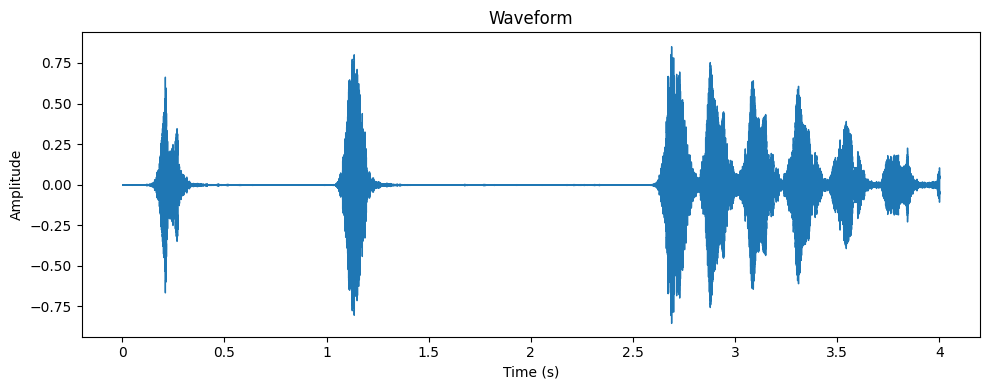

In [28]:
def display_waveform(audio_file, sr=44100):
    """
    Generates and displays the waveform of the given audio file.

    Args:
        audio_file (str): Path to the audio file.
        sr (int): Sampling rate of the audio (default: 44100).
    """
    # Load the audio
    y, sr = librosa.load(audio_file, sr=sr)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Input audio path
input_audio_path = 'UrbanSound8K/audio/fold1/101415-3-0-2.wav'

# Display the waveform
display_waveform(input_audio_path)

This plot visually represents the audio signal's amplitude over time of a **dog bark**. It shows the raw audio signal in the time domain, with the horizontal axis representing time (in seconds) and the vertical axis representing the amplitude (intensity) of the sound at each point in time.

This plot is useful for understanding the overall structure and duration of the audio, as well as identifying silent or loud regions, transients, or periodic patterns. However, it does not provide detailed information about the frequency content of the audio, which is captured by other features like **spectrograms** or **MFCCs**.


##### Mel Spectogram for a specific audio file

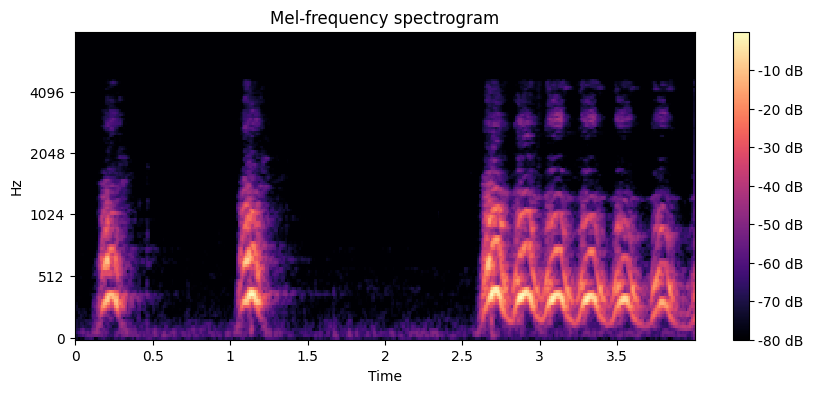

In [29]:
def display_spectrogram(audio_file, sr=44100, fmax=8000):
    """
    Generates and displays a mel-frequency spectrogram for the given audio file.

    Args:
        audio_file (str): Path to the audio file.
        sr (int): Sampling rate of the audio (default: 44100).
        fmax (int): Maximum frequency for the mel-frequency spectrogram (default: 8000).
    """
    # Load the audio
    y, sr = librosa.load(audio_file, sr=sr)
    
    # Compute the Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 4))
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=fmax, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')

    # Display the image in the notebook
    plt.show()

# Input audio path
input_audio_path = 'UrbanSound8K/audio/fold1/101415-3-0-2.wav'

# Generate and display the spectrogram
display_spectrogram(input_audio_path)


This shows how the energy of audio signals is distributed over frequency and time (as explained above). 

The bright areas indicate **higher energy** concentrated at specific frequencies, which is characteristic of a dog bark. 

The pattern reveals distinct intervals with bursts of energy and repeating harmonic structures, reflecting the short, sharp, and periodic nature of a typical bark. The onsets and decays visible in the spectrogram align with the rhythmic and energetic nature of dog vocalizations.

##### MFCCs for a specific audio file

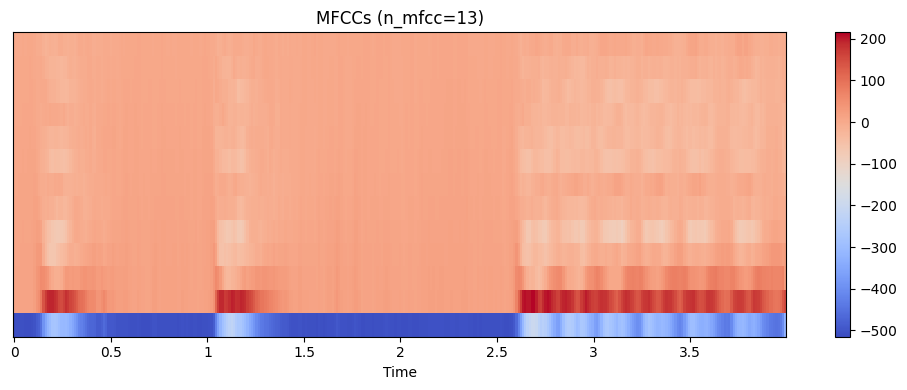

In [6]:
def display_mfcc(audio_file, sr=44100, n_mfcc=13):
    """
    Generates and displays the MFCCs for the given audio file.

    Args:
        audio_file (str): Path to the audio file.
        sr (int): Sampling rate of the audio (default: 44100).
        n_mfcc (int): Number of MFCCs to extract (default: 13).
    """
    # Load the audio
    y, sr = librosa.load(audio_file, sr=sr)

    # Compute the MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Plot the MFCCs
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.title(f'MFCCs (n_mfcc={n_mfcc})')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Input audio path
input_audio_path = 'UrbanSound8K/audio/fold1/101415-3-0-2.wav'

# Display the MFCCs
display_mfcc(input_audio_path)

This one displays the first 13 Mel-frequency cepstral coefficients (MFCCs) extracted from the audio, which represent the **spectral characteristics** of the sound over time. These coefficients capture key features of the audio's **timbre and texture**, particularly reflecting the overall shape of the sound's frequency spectrum. The horizontal axis represents time, while the vertical axis corresponds to the 13 MFCCs. Since only the first 13 MFCCs are extracted, the plot focuses on the most significant features of the audio signal, which are crucial for tasks like speech recognition and audio classification.

##### Waveform and MelSpectogram for all audio data

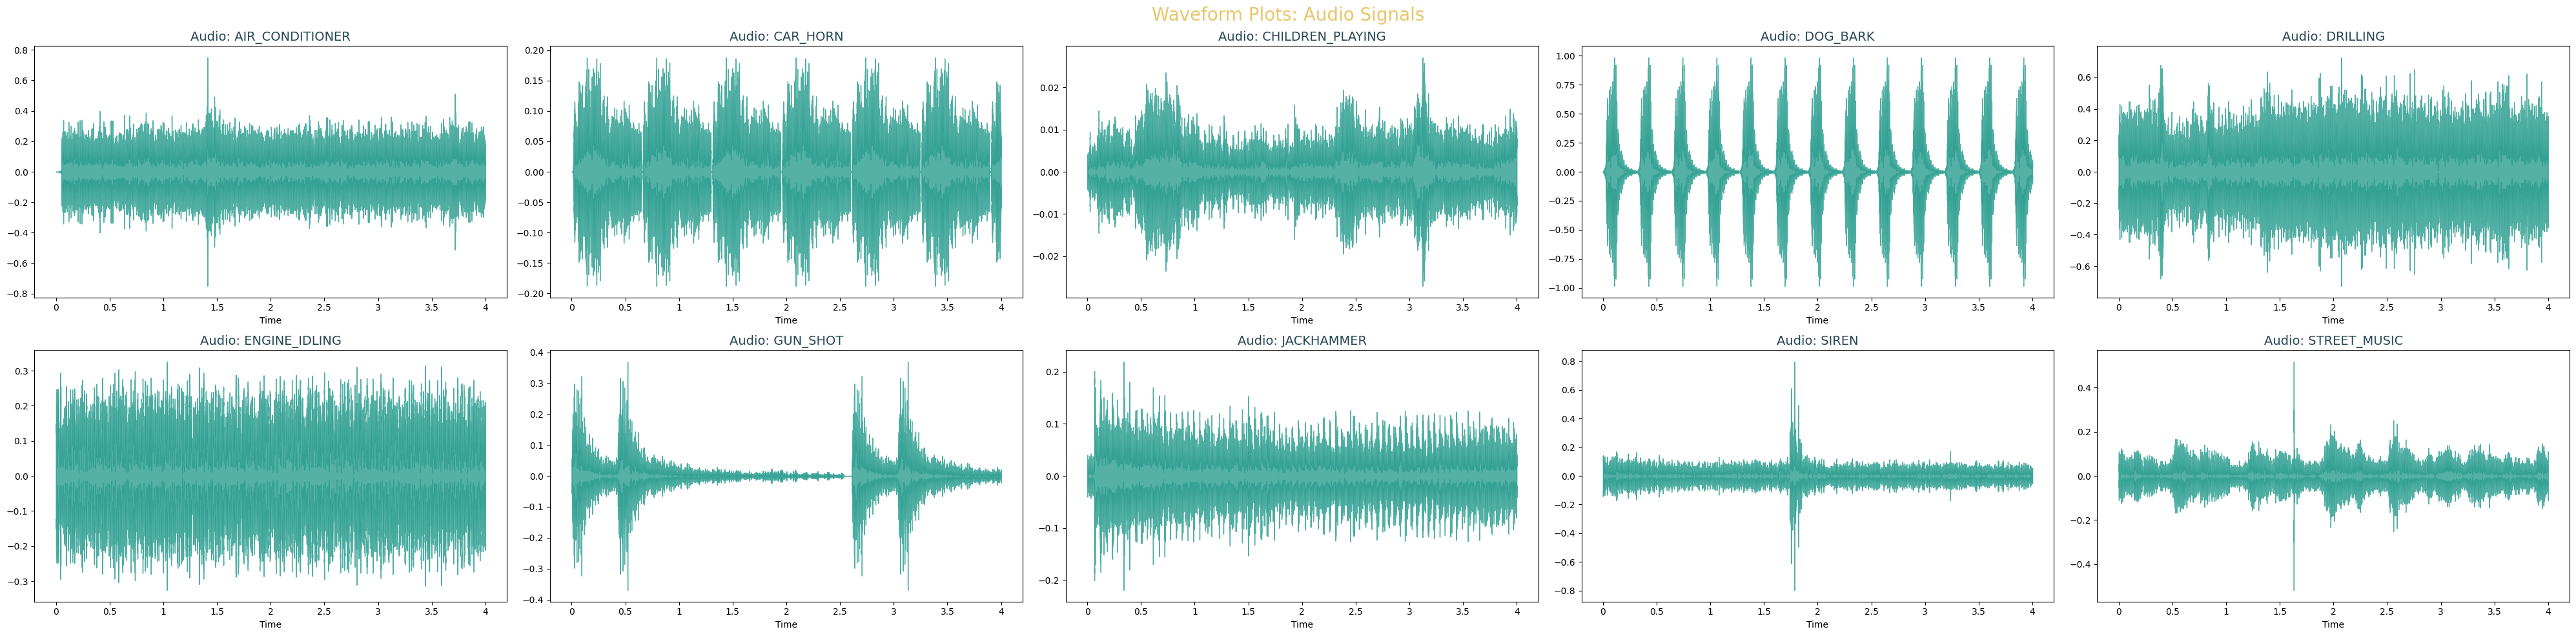

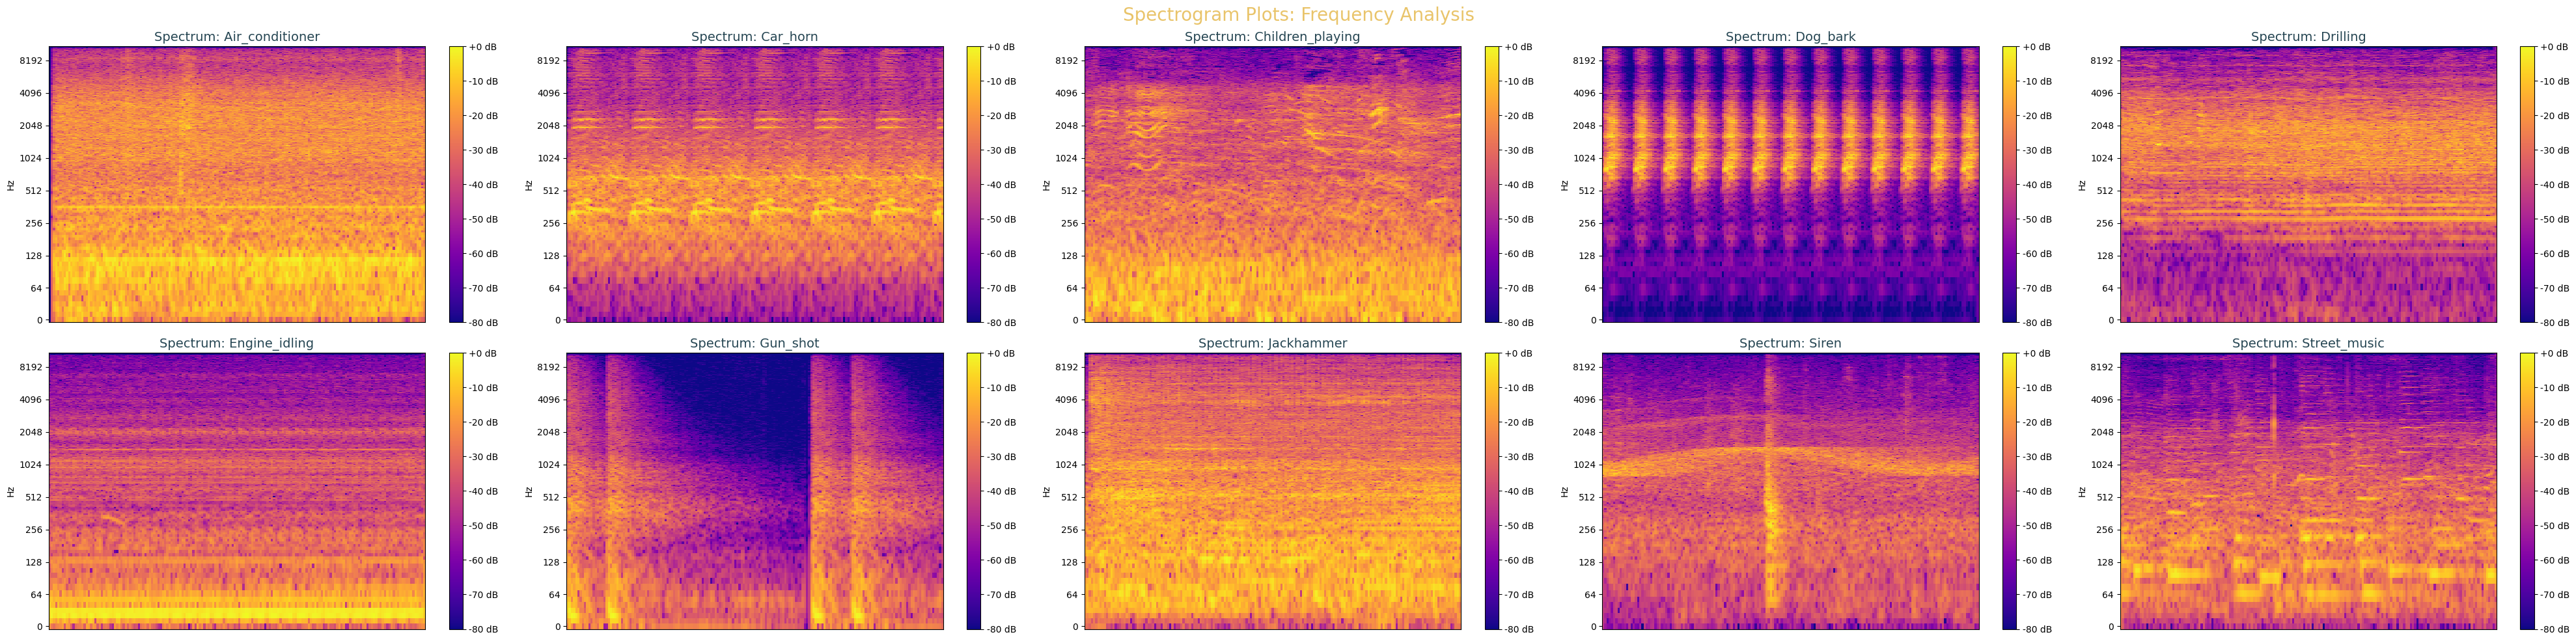

In [3]:
# Function to load audio files
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X, sr = librosa.load(fp, sr=None)  # sr=None to keep the original sample rate
        raw_sounds.append(X)
    return raw_sounds

# Function to plot the audio waveform
def plot_waves(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(40, 10))  # Larger figure size for better viewing

    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(2, 5, i)
        librosa.display.waveshow(np.array(f), sr=22050, color='#2a9d8f', alpha=0.8, where='post')  # Blue-green color
        plt.title(f"Audio: {n.upper()}", fontsize=14, color='#264653')  # Titles with a darker tone
        i += 1

    fig.suptitle('Waveform Plots: Audio Signals', fontsize=20, color='#e9c46a')  # Main title in yellow
    plt.tight_layout()
    plt.show()

# Function to plot the audio spectrogram
def plot_spec(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(40, 10))  # Adjusted figure size

    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(2, 5, i)
        d = librosa.amplitude_to_db(np.abs(librosa.stft(f)), ref=np.max)
        librosa.display.specshow(d, y_axis='log', cmap='plasma')  # Spectrogram with 'plasma' color map
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Spectrum: {n.capitalize()}", fontsize=14, color='#264653')  # Title with darker color
        i += 1

    fig.suptitle('Spectrogram Plots: Frequency Analysis', fontsize=20, color='#e9c46a')  # Main title
    plt.tight_layout()
    plt.show()

# Set CSV file path and get class list
path_csv = 'UrbanSound8K/metadata/UrbanSound8K.csv'
df = pd.read_csv(path_csv)

# Get list of classes from 'class' column in CSV
classes = list(np.unique(df['class']))

# Generate the list of audio file paths for viewing
sound_file_paths = [
    os.path.join('UrbanSound8K', 'audio', 'fold5', '100852-0-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold10', '100648-1-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold5', '100263-2-0-117.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold5', '100032-3-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold3', '103199-4-0-3.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold10', '102857-5-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold1', '102305-6-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold1', '103074-7-1-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold7', '102853-8-0-2.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold7', '101848-9-0-9.wav')
]

# Upload the audios
raw_sounds = load_sound_files(sound_file_paths)

# Plot waveforms and spectrograms
plot_waves(classes, raw_sounds)
plot_spec(classes, raw_sounds)


##### Label Distribution Across Data Folds

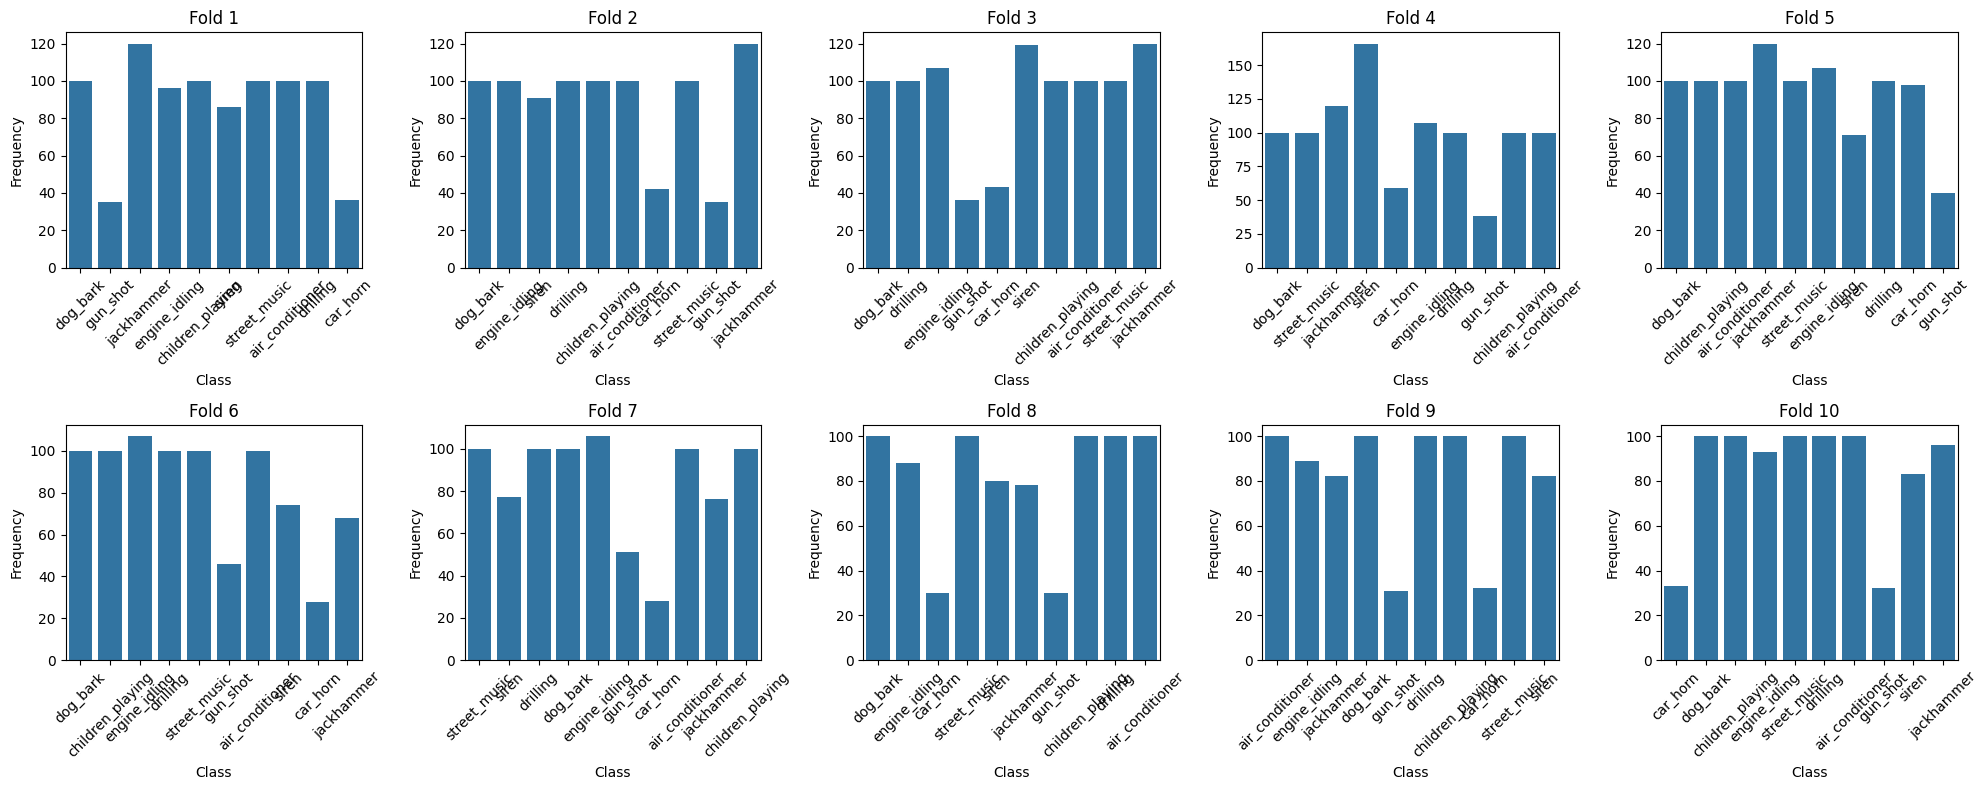

In [12]:
def plot_label_distribution_all_folds(csv_path, n_folds):
    """
    Plots the class distribution for each fold based on the UrbanSound8k metadata CSV file.
    
    :param csv_path: Path to the UrbanSound8k.csv file.
    :param n_folds: Total number of folds in the dataset.
    """
    # Load the CSV containing fold and class information
    df = pd.read_csv(csv_path)
    
    # Configure subplots
    nrows, ncols = 2, 5  # 2 rows and 5 columns for 10 folds
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
    
    for fold_number in range(1, n_folds + 1):
        # Filter samples for the current fold
        fold_data = df[df['fold'] == fold_number]
        
        # Determine subplot position
        row = (fold_number - 1) // ncols
        col = (fold_number - 1) % ncols
        
        # Plot histogram of classes
        sns.countplot(x=fold_data['class'], ax=axes[row, col])
        axes[row, col].set_title(f'Fold {fold_number}')
        axes[row, col].set_xlabel('Class')
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].tick_params(axis='x', rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
csv_path = "UrbanSound8K/metadata/UrbanSound8k.csv"
plot_label_distribution_all_folds(csv_path, 10)

The graphs show the **class distribution for each fold** in the UrbanSound8k dataset. Each subplot represents a **fold**, highlighting the frequency of audio samples per class. This helps evaluate class balance across folds for model training and validation.

### Cleaning the csvs <a name="cleaning"></a>
[[go back to the topic]](#data-cleaning)

In this section, we will perform data cleaning. This process will include the following steps:

- Check for Missing Values
- Check if there are any columns with object type
- Check for Duplicates
- Validate Column Data Types
- Normalization
- Label Encoding 

##### Missing values

In [65]:
def check_missing_values(df):
    missing_values = df.isnull().sum()
    if missing_values.any():
        print(f"  - Missing values detected:\n{missing_values[missing_values > 0]}")
    else:
        print("  - No missing values detected.")


##### Columns with object type

In [68]:
def check_object_columns(df):
    object_columns = df.select_dtypes(include=['object']).columns
    if object_columns.any():
        print(f"  - Columns with object data type: {object_columns.tolist()}")
    else:
        print("  - No columns with object data type detected.")


##### Duplicates

In [71]:
def check_duplicates(df):
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"  - {duplicates} duplicate rows found.")
        df = df.drop_duplicates()  
    else:
        print("  - No duplicate rows detected.")
    return df  

def drop_duplicates(df):
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"  - {duplicates} duplicate rows found.")
        df = df.drop_duplicates() 
    else:
        print("  - No duplicate rows detected.")
    return df

##### Column Data Types

In [74]:
def validate_column_data_types(df):
    column_data_types = df.dtypes
    print(f"  - Column data types:\n{column_data_types}")


##### Normalization
We opted for **MinMaxScaler** to normalize the audio features, as it scales the data to a fixed range (0-1), which is advantageous for neural networks. This choice was informed by insights from [this site](https://vitalflux.com/minmaxscaler-standardscaler-python-examples/), which highlights the benefits of using MinMaxScaler over StandardScaler for neural network applications.


In [77]:
def normalize_data(df):
    # Normalize numerical columns
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_columns) > 0:
        scaler = MinMaxScaler()
        
        df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
        print(f"Normalized values:\n{df[numeric_columns].describe()}")
        print(f"  - Normalized numeric columns: {numeric_columns.tolist()}")

    if 'Label' in df.columns:
        # Extract the classID from each filename
        df['Label'] = df['Label'].apply(lambda x: int(x.split('-')[1]) if isinstance(x, str) and len(x.split('-')) > 1 else None)
        print(f"Updated 'Label' column to 'classID' values.")
    
    return df


##### fourier_tempogram normalization
Since **fourier_tempogram** didn't normalize, that is, the values of it were extremly high, we decided to do a single normalization function to handle that feature in specific. 

In [80]:
def normalize_fourier_tempogram(df):
    """
    Normalizes the 'fourier_tempogram' column in the DataFrame using MinMaxScaler.
    """
    if 'fourier_tempogram' in df.columns:
        scaler = MinMaxScaler()
        df[['fourier_tempogram']] = scaler.fit_transform(df[['fourier_tempogram']])
        print("  - 'fourier_tempogram' normalized.")
    else:
        print("  - 'fourier_tempogram' column not found. Skipping normalization.")
    return df


##### Label Encoding
The primary reason for this choice was to reduce the dimensionality of the input data.
We used Label Encoding because neural networks in TensorFlow can process integer labels directly. One-Hot Encoding was unnecessary as it adds memory overhead without improving performance for this task.

In [83]:
def label_encode_data(df):
    """
    Performs Label Encoding on all object-type columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        df (pd.DataFrame): DataFrame with Label Encoding applied.
    """
    object_columns = df.select_dtypes(include=['object']).columns
    if len(object_columns) > 0:
        for col in object_columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            print(f"  - Label Encoding applied to column: {col}")
    else:
        print("  - No columns found for Label Encoding.")
    return df

##### Putting it All Together

In [86]:
folder_path = "datasets"
file_names = [f"urbansounds_features_fold{i}.csv" for i in range(1, 11)]
file_paths = [os.path.join(folder_path, file_name) for file_name in file_names]

# Iterar sobre os arquivos e processá-los
for i, file_path in enumerate(file_paths, 1):
    print(f"Data cleaning for file: {file_path}")
    
    # Carregar o dataset
    df = pd.read_csv(file_path)
    
    # 1. Check for missing values
    check_missing_values(df)
    
    # 2. Check for object-type columns
    check_object_columns(df)
    
    # 3. Check for duplicates
    df = drop_duplicates(df)
    
    # 4. Validate column data types
    validate_column_data_types(df)
    
    # 5. Normalize numeric columns
    df = normalize_data(df)

    # 6. Apply Label Encoding
    df = label_encode_data(df)

    # 7. Normalize fourier_tempogram
    df = normalize_fourier_tempogram(df)
    
    # Save the cleaned DataFrame to the same file
    df.to_csv(file_path, index=False)
    print(f"  - Cleaned data saved to: {file_path}")
    print("\n" + "-" * 50 + "\n")

Data cleaning for file: datasets\urbansounds_features_fold1.csv
  - No missing values detected.
  - Columns with object data type: ['fourier_tempogram', 'Label']
  - No duplicate rows detected.
  - Column data types:
chroma_stft          float64
chroma_cens          float64
melspectogram        float64
rms                  float64
centroid             float64
bandwidth            float64
contrast             float64
flatness             float64
rolloff              float64
crossing_rate        float64
tempogram            float64
fourier_tempogram     object
mfcc_1               float64
mfcc_2               float64
mfcc_3               float64
mfcc_4               float64
mfcc_5               float64
mfcc_6               float64
mfcc_7               float64
mfcc_8               float64
mfcc_9               float64
mfcc_10              float64
mfcc_11              float64
mfcc_12              float64
mfcc_13              float64
mfcc_14              float64
mfcc_15              float64


### Distribution of the classes on the generated datasets 

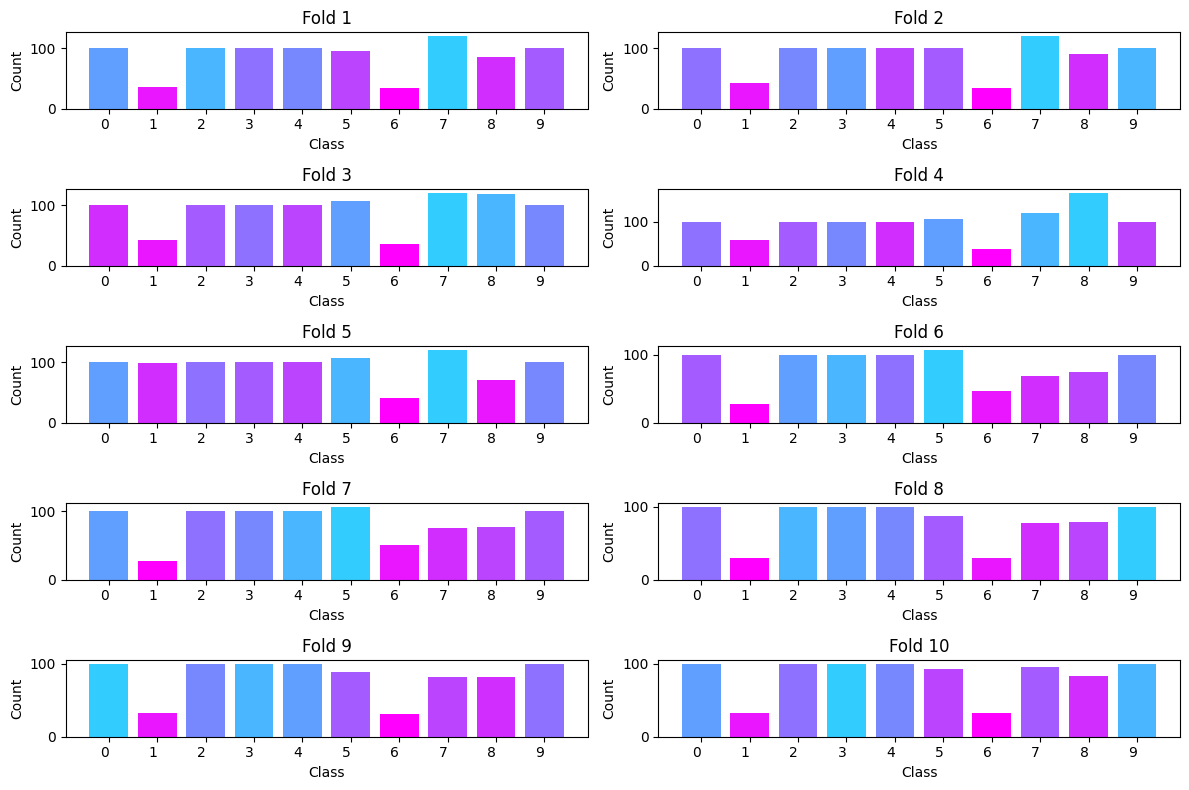

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution_from_files(folder_path, file_names):
    datasets = []
    
    # Carregar datasets a partir dos arquivos
    for file_name in file_names:
        file_path = f"{folder_path}/{file_name}"
        datasets.append(pd.read_csv(file_path))
    
    rows = int(np.ceil(len(datasets) / 2))
    cols = 2
    fig, axs = plt.subplots(rows, cols, figsize=(12, 8))
    cmap = plt.get_cmap('cool')

    for fold, (df, ax) in enumerate(zip(datasets, axs.flat), start=1):
        # Supondo que a coluna de rótulos seja chamada 'Label'
        class_counts = df['Label'].value_counts()
        class_labels = class_counts.index
        class_values = class_counts.values
        colors = cmap(np.linspace(0.2, 1, len(class_labels)))
        ax.bar(class_labels, class_values, color=colors)
        ax.set(xlabel='Class', ylabel='Count', title=f'Fold {fold}')
        ax.set_xticks(class_labels)
        ax.set_xticklabels(class_labels, rotation=0, ha='right')

    # Ajuste final para exibição
    plt.tight_layout()
    plt.show()

# Caminho para a pasta e nomes dos arquivos
folder_path = "datasets"
file_names = [f"urbansounds_features_fold{i}.csv" for i in range(1, 11)]

# Chamar a função para plotar
plot_class_distribution_from_files(folder_path, file_names)


Since we are done with all the data understanding and preparation, we are now ready to begin the implementation of our chosen models.

From now on, we will continue with the project in **two different notebooks**. The teacher can access the [[MLP]](./MLP.ipynb) file, in which will document the procedure and implementation for the **MLP classifier**, while the [[CNN]](./MLP.ipynb) file will focus on the **CNN classifier**. This separation ensures clarity and makes it easier for the teacher to follow each classifier's workflow individually.